In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import random
from scipy.spatial import KDTree
from shapely.geometry import LineString
import numpy.linalg as LA
import copy
import time
import math

In [4]:
class Plotter():
    def __init__(self,obstacles,xRange,yRange,qStart,qGoal):
        self.obstacles = obstacles
        self.xRange, self.yRange = xRange,yRange
        self.qStart,self.qGoal = qStart,qGoal
    
    def plotGraph(self,graph):
        xPoints,yPoints = [],[]
        for vi in list(graph.keys()):
            x,y = vi
            plt.scatter([x],[y])
            for neighbor in graph[vi]:
                nX,nY = neighbor
                plt.plot([x,nX],[y,nY], 'bo-')
    
    
    def plotPath(self,path,pathLength):
        plt.title(f"Path with Length {pathLength} found with A* on PRM Graph Created by Random Sampling")
        xPoints,yPoints = [],[]
        for vi in path:
            x,y = vi
            xPoints.append(x)
            yPoints.append(y)
        plt.plot(xPoints,yPoints,'ro-')
       
    
    def plotTree(self,tree,qGoal,pathLength):
        plt.title(f"Path with Length {pathLength} found using RRT*")

        # plot line between all nodes and their parent
        for child in list(tree.keys()):
            parent = tree[child]
            pX,pY = parent
            cX,cY = child
            plt.plot([pX,cX],[pY,cY], 'bo-')
           
        # searches backwards from qGoal to plot tree path
        currentNode = tuple(self.qGoal)
        pathLength = 0
        while tuple(currentNode) != tuple(self.qStart):
            parentNode = tree[currentNode]
            pX,pY = parentNode
            cX,cY = currentNode
            plt.plot([pX,cX],[pY,cY], 'ro-')
            currentNode = parentNode
            
        plt.show()
        
    def plotWorld(self,graph=None,path=None,pathLength=None,tree=None,qGoal=None):
        # plots path if path is list of vertices
        fig, ax = plt.subplots()
        ax.plot()
        for Oi in obstacles:
            v1,v2,v3,v4 = Oi
            x1,y1 = v1
            x3,y3 = v3
            r = Rectangle((x1,y1),x3-x1,y3-y1)
            ax.add_patch(r)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.xlim(self.xRange[0],self.xRange[1])
        plt.ylim(self.yRange[0],self.yRange[1])
        # plt.scatter([qStart[0],qGoal[0]],[qStart[1],qGoal[1]])
        plt.grid()
        if graph!=None:
            self.plotGraph(graph)
            
        if path!=None:
            self.plotPath(path,pathLength)
            
        if tree!=None:
            self.plotTree(tree,qGoal,pathLength)
            
        plt.show()

In [5]:
class CollisionChecker():
    def __init__(self,obstacles):
        self.obstacles = obstacles
    
    def lineLineIntersection(self,line1,line2):
        # each line is a tuple of end points ((x1,y1),(x2,y2))
        # returns true if line1 and line2 intersect
        (x1,y1),(x2,y2) = line1
        (x3,y3),(x4,y4) = line2
        line1String = LineString([line1[0], line1[1]])
        line2String = LineString([line2[0], line2[1]])
        return line1String.intersects(line2String)
        
    
    def getObstacleLines(self,obstacle):
        # obstacle is list of points for the obstacle
        # returns a list of lines given by pairs of points for all points on a given obstacle
        obstacleLines = [(obstacle[-1],obstacle[0])]
        for i in range(0,len(obstacle)-1):
            obstacleLines.append((obstacle[i],obstacle[i+1]))
        return obstacleLines

    def lineIntersectsObstacles(self,line):
        # returns true if a line between the points intersects any obstacles
        for obstacle in self.obstacles:
            obstacleLines = self.getObstacleLines(obstacle)
            for obstacleLine in obstacleLines:
                if self.lineLineIntersection(line,obstacleLine):
                    return True

        return False

In [38]:
class rrtPlanner():
    def __init__(self,obstacles,xRange,yRange,qStart,qGoal):
        self.obstacles = obstacles
        self.xRange,self.yRange = xRange,yRange
        self.xMin,self.xMax = xRange
        self.yMin,self.yMax = yRange
        self.qStart,self.qGoal = qStart,qGoal
        self.plotter = Plotter(obstacles,xRange,yRange,qStart,qGoal)
        self.collisionChecker = CollisionChecker(obstacles)
        
    def isFreeConfigurationSpace(self,q):
        # returns true if configuration q = (x,y) is in free space
        # all obstacles are rectangular so just check if within bounds
        x,y = q
        for obstacle in self.obstacles:
            v1,v2,v3,v4 = obstacle
            x1,y1 = v1
            x3,y3 = v3
            if x1<=x<=x3 and y1<=y<=y3:
                return False
        return True
    
    
    def isFreePath(self,v1,v2):
        # returns true if there is a path in free configuration space between v1 and v2 
        # checks if the line interesects any of the obstacles
        line = ((v1[0],v1[1]),(v2[0],v2[1]))
        if self.collisionChecker.lineIntersectsObstacles(line):
            return False
        return True
    
    def sampleVertex(self,pGoal):   
        # select goal with probability pGoal
        if np.random.uniform(0,1)<=pGoal:
            return tuple(self.qGoal)
        
        while True:
            # sample until a free configuration is found
            randX = np.random.uniform(self.xMin,self.xMax)
            randY = np.random.uniform(self.yMin,self.yMax)
            q = (randX,randY)
            # run until configuration is in free space
            if self.isFreeConfigurationSpace(q):
                return tuple(q)

    def getPathLength(self,qNew):
        # searches backwards from qGoal
        # print("Traversing backwards for path length")
        # print(self.tree)
        # currentNode = tuple(self.qGoal)
        currentNode = tuple(qNew)
        pathLength = 0
        while tuple(currentNode) != tuple(self.qStart):
            # print(currentNode)
            parentNode = self.tree[currentNode]
            pathLength += LA.norm(np.array(parentNode) - np.array(currentNode))
            currentNode = parentNode
        return pathLength
    
    
    def getBestControlInputs(self,Xi,Xf):
        # samples control inputs to go from state Xi to Xf
        # returns the final state, and input and time duration of corresponding control inputs which lead 
        # to the least error after the input is applied for dT seconds
        # Let's fix dT equal to 0.25 seconds
        x0,y0 = Xi
        vxRange = [-4,4]
        vyRange = [-4,4]
        dT = 0.25 # time duration control inputs are applied
        uBest = None
        minError = math.inf
        m = 200 # iterations to sample control inputs 
        for i in range(0,m):
            vx = np.random.uniform(vxRange[0],vxRange[1])
            vy = np.random.uniform(vyRange[0],vyRange[1])
            xF = x0 + (vx * dT)
            yF = y0 + (vy * dT)
            error = LA.norm(np.array([xF,yF]) - np.array([Xf[0],Xf[1]]))
            if error < minError:
                uBest = [vx,vy]
            
        return uBest
    
    def steer(self,qNearest,qRand):
        # Returns the state resulting from the best sampled control inputs to reach qRand from qNearest
        dT = 0.25
        vx,vy = self.getBestControlInputs(Xi=qNearest,Xf=qRand)
        x0,y0 = qNearest
        xF = x0+(vx*dT)
        yF = y0+(vy*dT)
        # print(f"Start is {qNearest}")
        # print(f"Goal is {qRand}")
        # print(f"Distance {LA.norm(qNearest-qRand)}")
        # print(f"Steering got {xF,yF}")
        return np.array([xF,yF])
        
    def generateTree(self,n,r,pGoal,epsilon):
        # returns tuple of (True,tree,qGoal,pathLength) if a path exists
        # returns tuple of (False,tree,qGoal,None) if a path does not exist
        # Add initial state to the tree
        self.treePoints = np.array([self.qStart])
        self.kdTree = KDTree(self.treePoints)
        self.tree = {} # maps from child to parent
        self.reverseTree = {} # maps from parent to child
        self.costs = {tuple(self.qStart):0.0} # maps from node to cost (path length from root)
        
        for i in range(0,n):
            if i%100 ==0:
                print(i)
            # (1) sample a random free configuration
            qRand = self.sampleVertex(pGoal)
            
            # (2) find closest point in tree to qRand 
            queryResult = self.kdTree.query(np.array(qRand),1)
            qNearestIndex = queryResult[1]
            qNearest = self.treePoints[qNearestIndex]
            
            # (3) generate point that is r units away from qNear in direction of qRand
            qRand = np.array(qNearest) + (r*(np.array(qRand) - np.array(qNearest))/LA.norm((np.array(qRand) - np.array(qNearest))))
            qRand = tuple(qRand)
            
            # (4) Apply the steering function to determine the best resulting state from sampled control inputs
            # assume qNew = qRand (perfect steering function)
            qNew = tuple(self.steer(qNearest,qRand))
            
            # (4) Add qNew to the tree with parent qNear if there is a free path between them
            if self.isFreePath(qNearest,qNew):
                self.treePoints = np.concatenate((self.treePoints,[qNew]),axis=0)
                self.kdTree = KDTree(self.treePoints) 
            else:
                # End this iteration of sampling
                continue 
            
            # (5) Iterate over configurations (XNear) within radius r of qNew
            # and compare the cost (total pathlength from root) of reaching qNew through each of them            
            # connecting through the closest node in the tree
            minCost = self.costs[tuple(qNearest)] + LA.norm(qNew - qNearest)
            minNeighbor = qNearest
            
            XNear = self.kdTree.query_ball_point(qNew,1)
            for neighborIndex in XNear:
                qNeighbor = self.treePoints[neighborIndex]
                if (not (qNeighbor==qNew).all()) and self.isFreePath(qNeighbor,qNew):
                    # print(qNeighbor,qNew)
                    # cost of path from root through qNeighbor to qNew
                    neighborCost = self.costs[tuple(qNeighbor)] + LA.norm(qNeighbor - qNew)
                    if neighborCost < minCost and abs(neighborCost-minCost)>0.001:
                        minCost = neighborCost
                        minNeighbor = qNeighbor
            
            # (6) store minNeighbor as the parent of new leaf node qNew
            # no issue here with child not having cost updated since qNew has no children 
            self.costs[tuple(qNew)] = self.costs[tuple(minNeighbor)] + LA.norm(minNeighbor - qNew)
            self.tree[tuple(qNew)] = tuple(minNeighbor)
            self.reverseTree[tuple(minNeighbor)] = tuple(qNew)
            
            
            # (6) 
            # Try to shorten the length of paths to root in the neighborhood of qNew
            # Iterate over nodes within radius r of qNew and if the existing path length
            # to these nodes is greater than an alternative path through qNew
            # then make qNew the parent of the node (qNeighbor) in the neighborhood   
            for neighborIndex in XNear:
                qNeighbor = self.treePoints[neighborIndex]
                currentCost = self.costs[tuple(qNeighbor)]
                alternativeCost = self.costs[tuple(qNew)] + LA.norm(qNeighbor - qNew)
                if not np.array_equal(qNeighbor,minNeighbor):
                    # check if there is a shorter length path to qNeighbor from qNew
                    if currentCost > alternativeCost and abs(currentCost-alternativeCost)>0.001 and self.isFreePath(qNeighbor,qNew):
                        # making qNew parent of qNeighbor to shorten path length to qNeighbor
                        initNeighborCost = self.costs[tuple(qNeighbor)]
                        self.costs[tuple(qNeighbor)] = self.costs[tuple(qNew)] + LA.norm(qNew - qNeighbor)
                        newNeighborCost = self.costs[tuple(qNeighbor)]                        
                        self.tree[tuple(qNeighbor)] = tuple(qNew)
                        self.reverseTree[tuple(qNew)] = tuple(qNeighbor)
                        # print(f"Cost decreased by {currentCost-alternativeCost}")
                        # Issue here is that if qNeighbor has children then we need to update the cost to them as well
                        # But let's ignore that for now
                        # let's check though if qNeighbor does have children
                        if tuple(qNeighbor) in self.reverseTree:
                            # this implies that qNeighbor has a child whose cost needs to be updated
                            # since the cost to qNeighbor has decreased
                            # print("qNeighbor has child whose cost needs to be updated")
                            # print(f"child: {self.reverseTree[tuple(qNeighbor)]}")
                            initChild = self.reverseTree[tuple(qNeighbor)]
                            child = initChild
                            parent = qNeighbor
                            '''
                            while True:
                                self.costs[tuple(child)] = self.costs[tuple(parent)] + LA.norm(np.array(child) - np.array(parent))
                                if tuple(child) in self.reverseTree:
                                    # if the child has children
                                    parent = child
                                    child = self.reverseTree[tuple(child)]
                                else:
                                    break
                            print(f"{time.time() - t0} sec spent updating children")
                            '''
                            '''
                            def updateChildCost(child,parent):
                                # print(f"{parent} has child {child}")
                                self.costs[tuple(child)] = self.costs[tuple(parent)] + LA.norm(np.array(child) - np.array(parent))

                                if tuple(child) in self.reverseTree:
                                    # if the child has children
                                    updateChildCost(self.reverseTree[tuple(child)],child)
                                    
                            # update the costs of qNeighbor's children and their children and so on...
                            updateChildCost(initChild,qNeighbor)
                            '''

            # (7) return path if qNew is within epsilon of qGoal
            # (7) Continue iterating if the goal is reached to improve path quality
            # Just store qNew in the tree without altering anything else
            
            if LA.norm(np.array(qNew) - np.array(self.qGoal)) <= epsilon:
                # Just in the case of returning the 1st result, add qGoal to tree 
                if tuple(qNew) != tuple(self.qGoal):
                    self.tree[tuple(self.qGoal)] = qNew
                    self.reverseTree[tuple(qNew)] = self.qGoal
                    # not sure bout line below 
                    self.costs[tuple(self.qGoal)] = self.costs[tuple(qNew)] + LA.norm(qNew - self.qGoal)

                # print(f"Path to goal found with cost length: {self.costs[tuple(qNew)]}")
                print(f"Path to goal found with length: {self.getPathLength(qNew)}")
                pathLength = self.getPathLength(qNew)
                return (True,self.tree,tuple(qGoal),pathLength)
                    
        return (False,self.tree,tuple(qGoal),None)

0
100
200
300
400
Path to goal found with length: 11.461698506352217


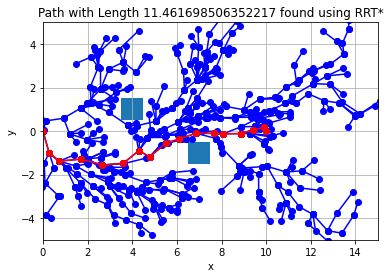

In [41]:
O1 = np.array([(3.5,0.5),(4.5,0.5),(4.5,1.5),(3.5,1.5)])
O2 = np.array([(6.5,-1.5),(7.5,-1.5),(7.5,-0.5),(6.5,-0.5)])
obstacles = [O1,O2]
qStart = np.array([0,0])
qGoal = np.array([10,0])
xRange = (0,15)
yRange = (-5,5)

r = rrtPlanner(obstacles,xRange,yRange,qStart,qGoal)
pathExists,tree,qGoal,pathLength = r.generateTree(n=10000,r=0.5,pGoal=0.05,epsilon=0.25)

if pathExists:
    
    # plots path if path is list of vertices
    fig, ax = plt.subplots()
    ax.plot()
    for Oi in obstacles:
        v1,v2,v3,v4 = Oi
        x1,y1 = v1
        x3,y3 = v3
        r = Rectangle((x1,y1),x3-x1,y3-y1)
        ax.add_patch(r)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(xRange[0],xRange[1])
    plt.ylim(yRange[0],yRange[1])
    # plt.scatter([qStart[0],qGoal[0]],[qStart[1],qGoal[1]])
    plt.grid()
    plt.title(f"Path with Length {pathLength} found using RRT*")

    # plot line between all nodes and their parent
    for child in list(tree.keys()):
        parent = tree[child]
        pX,pY = parent
        cX,cY = child
        plt.plot([pX,cX],[pY,cY], 'bo-')

    # searches backwards from qGoal to plot tree path
    currentNode = tuple(qGoal)
    pathLength = 0
    while tuple(currentNode) != tuple(qStart):
        parentNode = tree[currentNode]
        pX,pY = parentNode
        cX,cY = currentNode
        plt.plot([pX,cX],[pY,cY], 'ro-')
        currentNode = parentNode

    plt.show()
    
    '''
    r.plotter.plotWorld(pathLength=pathLength,
                        tree=tree,qGoal=qGoal)
    '''

In [63]:
O1 = np.array([(-6,-6),(25,-6),(25,-5),(-6,-5)]);
O2 = np.array([(-6,5),(30,5),(30,6),(-6,6)]);
O3 = np.array([(-6,-5),(-5,-5),(-5,5),(-6,5)]);
O4 = np.array([(4,-5),(5,-5),(5,1),(4,1)]);
O5 = np.array([(9,0),(10,0),(10,5),(9,5)]);
O6 = np.array([(14,-5),(15,-5),(15,1),(14,1)]);
O7 = np.array([(19,0),(20,0),(20,5),(19,5)]);
O8 = np.array([(24,-5),(25,-5),(25,1),(24,1)]);
O9 = np.array([(29,0),(30,0),(30,5),(29,5)]);
obstacles = [O1,O2,O3,O4,O5,O6,O7,O8,O9]
qStart = np.array([0,0])
qGoal = np.array([35,0])
xRange = (-7,36)
yRange = (-7,7)
r = rrtPlanner(obstacles,xRange,yRange,qStart,qGoal)
pathExists,tree,qGoal,pathLength = r.generateTree(n=5000,r=0.5,pGoal=0.05,epsilon=0.25)
if pathExists:
    r.plotter.plotWorld(pathLength=pathLength,tree=tree,qGoal=qGoal)

0
100
200
300
400
500
600
700
800
900
1000
1100
Path to goal found with length: 45.95676858056686
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400


KeyboardInterrupt: 